<a href="https://colab.research.google.com/github/LuisCGit/6.484-reinforcement-learning/blob/main/HW1_Assignment_on_Bandits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spring 2022 6.484 Computational Sensorimotor Learning Assignment 1
In this assignment, we will learn about multi-armed and contextual bandits.  You will need to <font color='blue'>answer the bolded questions</font> and <font color='blue'>fill in the missing code snippets (marked by **TODO**)</font>.

There are 170 total points in this assignment, scaled to be worth 6.25% of your final grade.

### Setup

Ignore the following skeleton code (imports, plotting).

In [2]:
%matplotlib inline
import numpy as np
import random
import time
import os
import gym
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd


from copy import deepcopy
from tqdm.notebook import tqdm
from dataclasses import dataclass
from typing import Any
mpl.rcParams['figure.dpi']= 100

In [3]:
# some util functions
def plot(logs, x_key, y_key, legend_key, **kwargs):
    nums = len(logs[legend_key].unique())
    palette = sns.color_palette("hls", nums)
    if 'palette' not in kwargs:
        kwargs['palette'] = palette
    ax = sns.lineplot(x=x_key, y=y_key, data=logs, hue=legend_key, **kwargs)
    return ax

def set_random_seed(seed):
    np.random.seed(seed)
    random.seed(seed)

# set random seed
seed = 0
set_random_seed(seed=seed)

# Multi-armed bandits

Let us define a multi-armed bandit scenario with 10 arms.  There are two slightly different formulations that are useful: 

- Stochastic Case: Each arm has a reward of 1, with probability $p \in [0, 1]$.
- Deterministic Case:  Each arm has a reward $r \in [0,1]$, but the same reward is obtained for every pull. 


In this assignment, we will work through the stochastic case.  The same insights would apply to the deterministic scenario with variable rewards or even to stochastic setups with variable rewards. 

To define our bandit, we arbitrarily select probabilities $p$ for each arm and save them as `probs`.



In [4]:
numArms = 10
probs = [np.random.random() for i in range(numArms)]
print(probs)

[0.5488135039273248, 0.7151893663724195, 0.6027633760716439, 0.5448831829968969, 0.4236547993389047, 0.6458941130666561, 0.4375872112626925, 0.8917730007820798, 0.9636627605010293, 0.3834415188257777]


We then define an environment to evaluate different agent strategies.

In [5]:
#To simulate a realistic Bandit scenario, we will make use of the BanditEnv.
@dataclass
class BanditEnv:
    probs: np.ndarray # probabilities of giving positive reward for each arm

    def step(self, action):
        # Pull arm and get stochastic reward (1 for success, 0 for failure)
        return 1 if (np.random.random()  < self.probs[action]) else 0

In [6]:
#Code for running the bandit environment. 
@dataclass
class BanditEngine:
    probs: np.ndarray
    max_steps: int
    agent: Any

    def __post_init__(self):
        self.env = BanditEnv(probs=self.probs)
    
    def run(self, n_runs=1):
        log = []
        for i in tqdm(range(n_runs), desc='Runs'):
            run_rewards = []
            run_actions = []
            self.agent.reset()
            for t in range(self.max_steps):
                action = self.agent.get_action()
                reward = self.env.step(action)
                self.agent.update_Q(action, reward)
                run_actions.append(action)
                run_rewards.append(reward)
            data = {'reward': run_rewards, 
                    'action': run_actions, 
                    'step': np.arange(len(run_rewards))}
            if hasattr(self.agent, 'epsilon'):
                data['epsilon'] = self.agent.epsilon
            run_log = pd.DataFrame(data)
            log.append(run_log)
        return log

In [7]:
#Code for aggregrating results of running an agent in the bandit environment. 
def bandit_sweep(agents, probs, labels, n_runs=2000, max_steps=500):
    logs = dict()
    pbar = tqdm(agents)
    for idx, agent in enumerate(pbar):
        pbar.set_description(f'Alg:{labels[idx]}')
        engine = BanditEngine(probs=probs, max_steps=max_steps, agent=agent)
        ep_log = engine.run(n_runs)
        ep_log = pd.concat(ep_log, ignore_index=True)
        ep_log['Alg'] = labels[idx]
        logs[f'{labels[idx]}'] = ep_log
    logs = pd.concat(logs, ignore_index=True)
    return logs


Credits: The code for Multi-Arm Bandits is inspired from

* https://github.com/ShangtongZhang/reinforcement-learning-an-introduction/blob/master/chapter02/ten_armed_testbed.py

* https://github.com/lilianweng/multi-armed-bandit/blob/master/solvers.py

## Oracle Agent

The best agent we could possibly build is one that has access to all the necessary information to make an optimal decision, even if that information would not be available in a real world problem.  We call this an "oracle agent."  

Imagine you were to build an Oracle agent for the stochastic multi-armed bandits problem defined by `probs`.  What reward would you get from this agent in expectation?

In [8]:
#### TODO: find the maximum return with priviledged infromation about the reward distribution [5pts] ####

##################################
oracleReward = max(probs)
print (f'Max possible reward {oracleReward}')

Max possible reward 0.9636627605010293


## Random Agent

That's pretty high reward!  However, let's say that we don't have access to `probs`, and that the only information we can learn about the environment is through interaction.  This is more akin to a real world bandits problem.

One baseline agent we should construct is one that chooses a random action at every timestep.  Fill in the `TODO` in the below agent code to implement this behavior.

In [9]:
#As a baseline, lets first construct a baseline agent that chooses a random action at every timestep. 
#We will measure how much better we can do. 
@dataclass
class RandomAgent:
    num_actions: int

    def __post_init__(self):
        self.reset()

    def reset(self):
        self.t = 0
        self.action_counts = np.zeros(self.num_actions, dtype=np.int) # action counts n(a)
        self.Q = np.zeros(self.num_actions, dtype=np.float) # action value Q(a)

    def update_Q(self, action, reward):
        pass

    def get_action(self):
        self.t += 1
        #### TODO: get a random action index [5pts]####
        ##################################

        selected_action = np.random.randint(self.num_actions) 
        return selected_action

In [10]:
#Create the random agent.
agent = RandomAgent(num_actions=len(probs))
'''
In order to measure average behavior of the agent, we are going to run the agent
multiple times and compute the mean reward. The number of runs will be denoted 
by the variable `n_runs`. The default value is set to 1000, but feel free to reduce it
it if its taking too much time. 
'''
n_runs = 1000
logs_random = bandit_sweep([agent], probs, ['Random'], n_runs=n_runs)

  0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

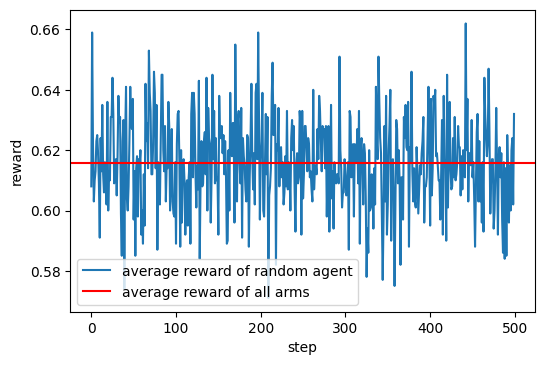

In [11]:
#### TODO: plot the reward curve of a random agent, and the average reward of all arms [5pts]####

###############################
def plot_avg_reward(logs, x_key, y_key, legend_key, **kwargs):
    logs = logs.groupby("step").mean()
    nums = len(logs[legend_key].unique())
    palette = sns.color_palette("hls", nums)
    if 'palette' not in kwargs:
        kwargs['palette'] = palette
    ax = sns.lineplot(x=x_key, y=y_key, data=logs, **kwargs, label = "average reward of random agent")
    return ax

ax = plot_avg_reward(logs_random, "step", "reward", "action")
ax.axhline(y=np.mean(probs),color="red",label = "average reward of all arms")
plt.legend()

**Analyzing the Results:** 
- On the x-axis is the number of steps taken by the agent. 
- On the y-axis is the average reward after $i$ steps.

The reward obtained by the random agent is far less that the oracle agent. Regret is defined as the difference between the the reward collected by oracle and the agent under consideration. In the above example, regret is about 0.35. 

**Note:** that if you use a different random seed to run experiments, you might get a slighly different value of regret. Treat this as a ball park figure. 

## Explore First Agent

In the class we discussed an algorithm to solve bandits where, 
- For the first N (defined as `max_explore` in the code) steps the agent takes random actions. 
- The agent identifies the best arm based on these N steps and then only chooses the best arm. 

We will now implement this agent below.  Fill in the missing code in `update_Q` and `get_action`.  We will store the average reward for each action in the variable `self.Q`, and the count of how many times we've taken each action in `self.action_counts`.

In [12]:
#Lets now construct the explore first agent  
@dataclass
class ExploreFirstAgent:
    num_actions: int
    max_explore: int

    def __post_init__(self):
        self.reset()

    def reset(self):
        self.t = 0
        self.action_counts = np.zeros(self.num_actions, dtype=np.int) # action counts n(a)
        self.Q = np.zeros(self.num_actions, dtype=np.float) # action value Q(a)

    def update_Q(self, action, reward):
        # Update Q action-value given (action, reward)
        # HINT: Keep track of how good each arm is
        #### TODO: update Q value [5pts] ####
        #if self.t <= self.max_explore:
        self.Q[action] = (self.Q[action]*self.action_counts[action] + reward)/(self.action_counts[action]+1)
        self.action_counts[action] += 1
        # else:
        #   pass

    def get_action(self):
        self.t += 1
        #### TODO: get action [5pts] ####
        if self.t <= self.max_explore:
          selected_action = np.random.randint(self.num_actions)
        else:
          selected_action = np.argmax(self.Q)

        return selected_action        

Great! Now we'll instantiate the engine, and run it with $N=5$ (five steps of exploration, followed by entirely greedy policy).

  0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

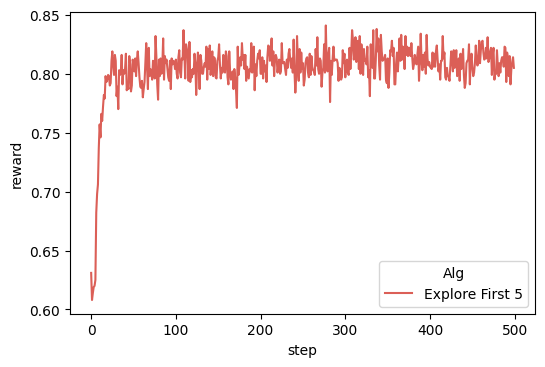

In [13]:
max_explore = 5
agent = ExploreFirstAgent(num_actions=len(probs), max_explore=max_explore)
logs = bandit_sweep([agent], probs, ['Explore First 5'], n_runs=1000, max_steps=500)
plot(logs, x_key='step', y_key='reward', legend_key='Alg', estimator='mean', ci=None)

### Explore First v.s. Random Agent

The results clearly show that the explore first agent performs better than the random agent. However, it still performs much worse than the oracle. How can we improve our performance? 

If there are 10 possible actions but the agent only explores for 5 steps, then it is likely it won't find the best arm.  Thus, the policy will be suboptimal. Let's see what happens when we allow the agent to explore for more steps. 


  0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

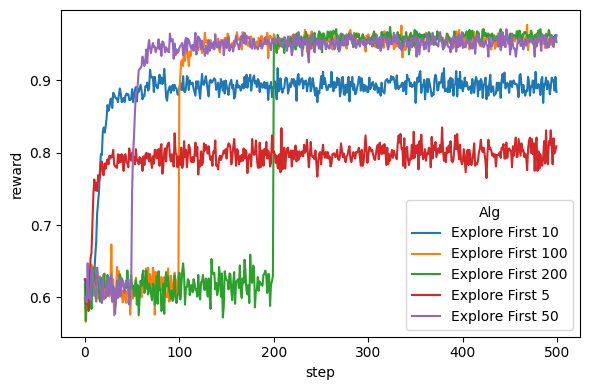

In [14]:
'''
What happens if we allow the agent to explore for only 5, 10, 50, 100, 200 steps respectively?
'''
#### TODO: run ExploreFirstAgent with different max_explore steps, and plot the reward curves [10pts]####
max_explore_steps = [5, 10, 50, 100, 200]
n_runs = 1000

logs_all = pd.DataFrame()
for i,max_explore in enumerate(max_explore_steps):
  agent = ExploreFirstAgent(num_actions=len(probs), max_explore=max_explore)
  logs = bandit_sweep([agent], probs, ['Explore First ' + str(max_explore)], n_runs=n_runs, max_steps=500)
  logs_all = pd.concat((logs_all,logs),axis=0)
data = logs_all.groupby(['step','Alg']).mean().sort_values('Alg')
ax = sns.lineplot(data = data, x = "step", y = "reward", hue = "Alg")
plt.tight_layout()


**Analyzing the Results** 

- Notice that for all agents there is a jump in performance. This corresponds to the time point when they switch from explore only to exploit mode. 

- The agents that explore for 5, 10 steps are unable to accurately identify the best arm everytime. Their scores are lower than that of agents exploring for 50 or 100 steps. These agents find the optimal arm. 

**Moving to More Realistic Scenarios**

**Question (5pts)**:
It's unclear how long the agent should explore before switching to exploit mode.  Can you come up with a strategy to choose a good value of `max_explore`? Can we use such a strategy to deploy a product?

**Answer**: 

Let us suppose that we have explore for $m$ steps. For a reasonable exploration, we probably want to try each arm at least once. Thus, if we set `max_explore` $= mK $, we expect to try every arm $m$ times. Setting too high an $m$ will waste too much time on exploration whilst setting too small an $m$ will lead to bad estimated rewards for each arm. In practice, $m = T^{2/3}$ can be a good choice. It can be difficult to deploy a product with this strategy because it can happen that $T^{2/3}K > T$ or that we do not know $T$ in advance. In such cases, we would need to resort to different heuristics.

## UCB Agent

Rather than having a fixed delineation between exploration and exploitation, an agent should be able to figure out when to explore and when to exploit.  This leads us to the UCB agent that we discussed in class. 

Implement the `update_Q` and `get_action` methods for a UCB agent using the course notes.

In [15]:
#### UCB Agent #### 
@dataclass
class UCBAgent:
    num_actions: int

    def __post_init__(self):
        self.reset()

    def reset(self):
        self.t = 0
        self.action_counts = np.zeros(self.num_actions, dtype=np.int) # action counts n(a)
        self.Q = np.zeros(self.num_actions, dtype=np.float) # action value Q(a)

    def update_Q(self, action, reward):
        # Update Q action-value given (action, reward)
        #### TODO: Calculate the Q-value [5pts] ####
        # self.Q[action] = (self.Q[action]*self.action_counts[action] + reward)/(self.action_counts[action]+1)
        # self.action_counts[action] += 1
        self.action_counts[action] += 1
        self.Q[action] += (1.0 / self.action_counts[action]) * (reward - self.Q[action])
        ###############################
        
    def get_action(self):
        self.t += 1
        ## HINT: To avoid a division by zero, you can add a small delta>0 to the denominator
        #### TODO: Calculate the exploration bonus [5pts] ####
        delta = 0.0001
        exploration_bonus = [np.sqrt(4 * np.log(self.t) / (k + delta)) for k in self.action_counts]
        ###########################################
        Q_explore = self.Q + exploration_bonus
        return np.random.choice(np.where(Q_explore == Q_explore.max())[0])

  0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

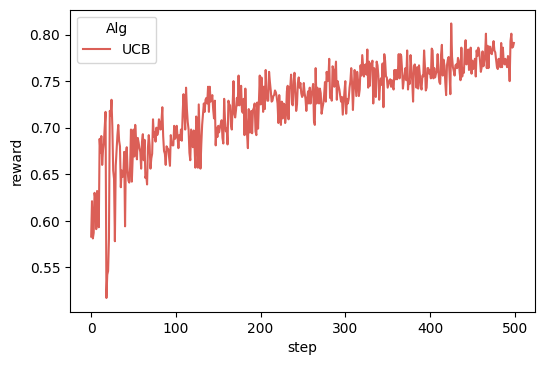

In [16]:
#Define the UCB Agent
agentUCB = UCBAgent(num_actions=len(probs))
#Compute Performance
logsUCB = bandit_sweep([agentUCB], probs, ['UCB'], n_runs=1000, max_steps=500)
#Plot Performance
plot(logsUCB, x_key='step', y_key='reward', legend_key='Alg', estimator='mean', ci=None)

### UCB v/s Explore-First

Now let's compare the reward curves of the `UCB` agent and `Explore First` agent with `max_explore=5`.

**Analyzing the Results**

**Question [5pts]**: Why does the UCB algorithm learn slowly (even after 500 steps, the agent still does not reach the maximum reward)?

**Answer**: The exploration bonus is probably dominating the exploitation term for many arms, which stops the algorithm from switching to a more exploitative strategy within the given numnber of steps.


  0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

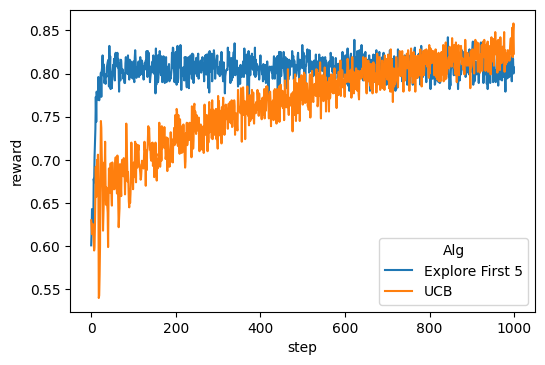

In [17]:
#Now we will compare the UCB agent against the ExploreFirst Agent that only explores for 5 steps.
#### TODO: run both algorithms and plot the reward curves (max_explore=5) [10pts] ####
#### use legends ['UCB', 'Explore First 5'] respectively 
#### run each algorithm 1000 times (n_runs=1000), and max_steps=1000

max_explore=5
agent = ExploreFirstAgent(num_actions=len(probs), max_explore=max_explore)
logs = bandit_sweep([agent], probs, ['Explore First ' + str(max_explore)], n_runs=1000, max_steps=1000)
agentUCB = UCBAgent(num_actions=len(probs))
logsUCB = bandit_sweep([agentUCB], probs, ['UCB'], n_runs=1000, max_steps=1000)
logs_all = pd.concat((logs,logsUCB),axis=0)

data = logs_all.groupby(['step','Alg']).mean().sort_values('Alg')
ax = sns.lineplot(data = data, x = "step", y = "reward", hue = "Alg")
##################################

**Result Analysis:** UCB outperforms the greedy Explore First agent that only explores for 5 steps. 

What happens if we allow the agent to explore for more steps?  Run the Explore First agent for 20 steps, and compare the reward to the UCB agent.

  0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

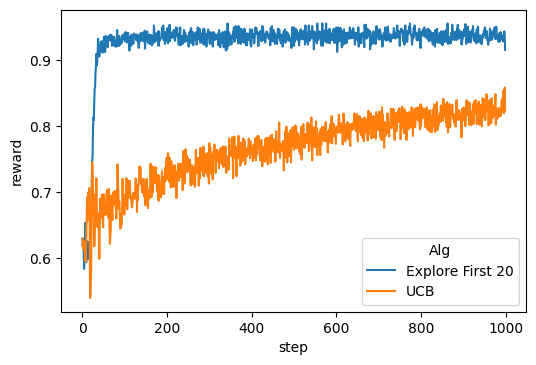

In [18]:
#Lets compare UCB with an agent that explores for twenty steps.
#### TODO: run both algorithms and plot the reward curves (max_explore=20) [10pts] #### 
#### use legends ['UCB', 'Explore First 20'] respectively
#### run each algorithm 1000 times (n_runs=1000), and max_steps=1000

max_explore=20
agentExp = ExploreFirstAgent(num_actions=len(probs), max_explore=max_explore)
logs = bandit_sweep([agentExp], probs, ['Explore First ' + str(max_explore)], n_runs=1000, max_steps=1000)
logs_all = pd.concat((logs,logsUCB),axis=0)

data = logs_all.groupby(['step','Alg']).mean().sort_values('Alg')
ax = sns.lineplot(data = data, x = "step", y = "reward", hue = "Alg")

##################################

**Question**: In the lecture we studied that the UCB algorithm is optimal. Why then does Explore First perform better?**

**Answer**: We showed that the UCB algorithm has better theoretical guarantees, but better asymptotic performance need not always imply better performance in practice. In this case, it's likely we would need many more time steps for the asympotic optimality of UCB to show.

### Skewed Arms Scenario:

In the previous example, the probability of each arm providing a return was sampled uniformly from $[0,1]$. Because there were only 10 arms, and some arms had similar returns, by performing 20 random actions it is possible to find the best arm by chance. However, if the reward distributions are very skewed (e.g., only one arm returns rewards with high probability, say 0.9), or there are more arms, more actions may be necessary. In this case the initial exploration phase may not succeed at finding the best arm. Lets see this in practice below. 

  0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

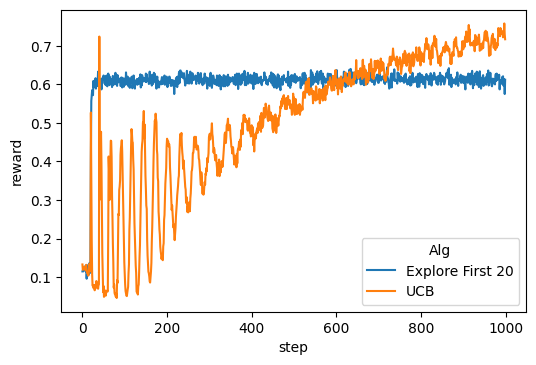

In [19]:
skewedProbs = [0.1, 0.2, 0.15, 0.21, 0.3, 0.05, 0.9, 0.13, 0.17, 0.07, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]
#### TODO: compare the reward curves of UCBAgent and ExploreFirstAgent (max_explore=len(skewedProbs)) [10pts] ####
#### sweep with n_runs=1000, max_steps=1000
max_explore=len(skewedProbs)
agentExp = ExploreFirstAgent(num_actions=len(skewedProbs), max_explore=max_explore)
logs = bandit_sweep([agentExp], skewedProbs, ['Explore First ' + str(max_explore)], n_runs=1000, max_steps=1000)
agentUCB = UCBAgent(num_actions=len(skewedProbs))
logsUCB = bandit_sweep([agentUCB], skewedProbs, ['UCB'], n_runs=1000, max_steps=1000)
logs_all = pd.concat((logs,logsUCB),axis=0)

data = logs_all.groupby(['step','Alg']).mean().sort_values('Alg')
ax = sns.lineplot(data = data, x = "step", y = "reward", hue = "Alg")
###################################

In this case, UCB performs better than *Explore First (20)*. It is because exploring for 20 steps is insufficient for this problem. This problem again illustrates that unless one has access to privileged information about the problem, UCB performs the best! 

Also notice that UCB's reward is still increasing and it hasn't converged to the optimal action yet. Try varying the maximum number of steps to see when UCB converges to the optimal / oracle policy. 

In other words, `max_explore` is a hyperparameter. Without "tuning" it, the method may perform well on some problem instances and poorly on others. An advantage of UCB is its lack of hyperparameters. Next, we'll consider another hyperparameter, $\epsilon$.

  0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

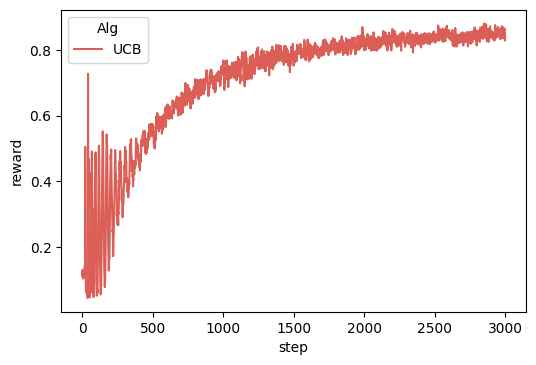

In [20]:
#time to converge to optimal policy
agentUCB = UCBAgent(num_actions=len(skewedProbs))
logsUCB = bandit_sweep([agentUCB], skewedProbs, ['UCB'], n_runs=1000, max_steps=3000)
plot(logsUCB, x_key='step', y_key='reward', legend_key='Alg', estimator='mean', ci=None)

## Epsilon-greedy Agent

Another popular method of simultaneoulsy exploring/exploiting is $\epsilon$-greedy exploration. The main idea is to:
- Sample the (estimated) best action with probability $1-\epsilon$
- Perform a random action with probability $\epsilon$ 

By changing $\epsilon$, we can control if the agent is conservative or exploratory. We will now implement this agent. 

In [21]:
##EpsilonGreedy Agent
@dataclass
class EpsilonGreedyAgent:
    num_actions: int
    epsilon: float = 0.1

    def __post_init__(self):
        self.reset()

    def reset(self):
        self.action_counts = np.zeros(self.num_actions, dtype=np.int) # action counts n(a)
        self.Q = np.zeros(self.num_actions, dtype=np.float) # action value Q(a)

    def update_Q(self, action, reward):
        # Update Q action-value given (action, reward)
        self.action_counts[action] += 1
        self.Q[action] += (1.0 / self.action_counts[action]) * (reward - self.Q[action])

    def get_action(self):
        # Epsilon-greedy policy
        #### TODO: Code for exploration [5pts] ####
        if np.random.random() <= 1 - self.epsilon:
          selected_action = np.argmax(self.Q)
        else:
          selected_action = np.random.randint(self.num_actions)
        ##################################

        return selected_action

**Analyzing Epsilon-Greedy Agents** 

Notice that the reward of all agents gradually increases (except for $\epsilon=0$, which is an extremely greedy agent). Also, notice that reward is maxmium for $\epsilon=0.1$ but decreases for higher values. 

**Question [5pts]**: Why is the reward lower for higher-values of $\epsilon$?

**Answer**: Because for values of $\epsilon$ which are too high, the agent cannot effectively exploit what it has learned, because it is forced to act randomly too often. On the other hand, with very low values of $\epsilon$ the agent becomes too exploitative and does not explore enough.


**Question [5pts]**: To overcome the issue above, one can try setting $\epsilon=0$ after some time or adaptively chaning $\epsilon$. Can you suggest a strategy for varying $\epsilon$ with time $T$?

**Answer**: We want the agent to be able to explore more in the beginning (higher $ϵ$) and then less at later stages, when were are more confident about which arm is optimal. A decay schedule which might accomplish this is $\epsilon = 1/T$. Thus, in the limit, we have a completely greedy agent which only chooses the arm with the highest mean reward.

**Consider**: Compare $\epsilon$-greedy with UCB and the tradeoffs.

Pros: faster convergence with the right $\epsilon$.

Con: requires tuning a hyperparameter, unlike UCB.

  0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

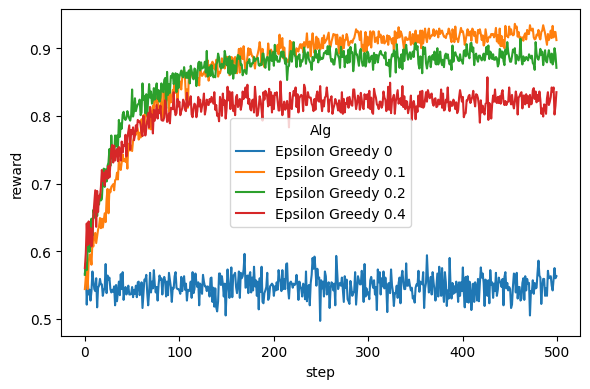

In [22]:
#### TODO: show reward curves of an EpsilonGreedyAgent with epsilon=[0, 0.1, 0.2, 0.4] [10pts]####
epsilons = [0, 0.1, 0.2, 0.4]
n_runs = 1000
max_steps = 500
logs_all = pd.DataFrame()
for i,epsilon in enumerate(epsilons):
  agent = EpsilonGreedyAgent(num_actions=len(probs), epsilon=epsilon)
  logs = bandit_sweep([agent], probs, ['Epsilon Greedy ' + str(epsilon)], n_runs=n_runs, max_steps=max_steps)
  logs_all = pd.concat((logs_all,logs),axis=0)
data = logs_all.groupby(['step','Alg']).mean().sort_values('Alg')
ax = sns.lineplot(data = data, x = "step", y = "reward", hue = "Alg")
plt.tight_layout()
###########################################

# Contextual bandits

In this section, we will deal with contextual bandits problem. In contextual bandits, we use contextual information about the observed subject to make subject-specific decisions.  The algorithm we will implement is called [LinUCB](https://arxiv.org/pdf/1003.0146.pdf).

As an example, imagine we have a website with 10 products that we'd like to promote. Whenever a user enters the website, the website promotes one product to the user. If the user clicks the product link, then it's a successful promotion (reward is $1$). Otherwise, it's a failed promotion (reward is $0$). Our goal is to optimize the click through rate (CTR), and thus optimize our $$$. 

We will use a dataset from [here](http://www.cs.columbia.edu/~jebara/6998/dataset.txt) to explore contextual bandits.  The dataset contains a pre-logged array of shape $[10000, 102]$. Each row represents a data point at time step $t$ where $t\in[0, 9999]$. The first column represents the index of the arm $a_t$ that's chosen ($10$ arms in total). The second column represents the reward $r_t\in\{0,1\}$ received for taking the selected arm. The last $100$ columns represent the context feature vector. 

The following code is inspired by [this code repository](https://github.com/kfoofw/bandit_simulations).

In [23]:
# Download the dataset
!wget http://www.cs.columbia.edu/~jebara/6998/dataset.txt

--2022-02-10 00:45:12--  http://www.cs.columbia.edu/~jebara/6998/dataset.txt
Resolving www.cs.columbia.edu (www.cs.columbia.edu)... 128.59.11.206
Connecting to www.cs.columbia.edu (www.cs.columbia.edu)|128.59.11.206|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2149159 (2.0M) [text/plain]
Saving to: ‘dataset.txt.2’

dataset.txt.2       100%[===================>]   2.05M  --.-KB/s    in 0.1s    

2022-02-10 00:45:12 (15.4 MB/s) - ‘dataset.txt.2’ saved [2149159/2149159]



In [24]:
# load in the dataset
#### TODO: load in the dataset.txt, and extract the data as a numpy array of shape [10000, 102] ####
data = pd.read_csv('dataset.txt', sep=" ", header=None)
data = data.iloc[:, :-1]
print(f'Dataset shape:{data.shape}')
data[0] -= 1 # we use 0-based numbering
data = data.to_numpy()

Dataset shape:(10000, 102)


In [25]:
#### Contextual bandit environment ####
@dataclass
class ContextualBanditEnv:
    dataset: Any
    t: int = 0

    def step(self, action):
        # if the action matches the recorded action in the dataset, it will
        # return the recorded reward in the dataset. Otherwise, it will return
        # a reward of None
        if action == self.dataset[self.t, 0]:
            reward = self.dataset[self.t, 1]
        else:
            reward = None
        self.t += 1
        return reward
    
    def reset(self):
        self.t = 0

Fill in the missing code below to implement the LinUCB agent.

In [26]:
from numpy.ma.core import reshape
#### LinUCB Agent #### 
@dataclass
class LinUCBAgent:
    num_actions: int
    alpha: float
    feature_dim: int

    def __post_init__(self):
        self.reset()

    def reset(self):
        self.As = [np.identity(self.feature_dim) for i in range(self.num_actions)]
        self.bs = [np.zeros([self.feature_dim, 1]) for i in range(self.num_actions)]
      
    def get_ucb(self, action, state):
            #### TODO: compute the UCB of the selected action/arm, and the context information [5pts] ####
            p = state.reshape((1,len(state))) @ np.linalg.inv(self.As[action]) @ self.bs[action]
            return p


    def update_params(self, action, reward, state):
        #### update A matrix and b matrix given the observed reward, ####
        #### selected action, and the context feature                ####
        if reward is None:
            return        
        #### TODO: update A and b matrices of the selected arm [5pts] ####
        state = state.reshape((len(state),1))
        self.As[action] = self.As[action] + state @ state.T
        self.bs[action] = self.bs[action] + reward * state

    def get_action(self, state):
        #### find the action given the context information ####

        #### TODO: get the UCB estimates for all actions [5pts] ####
        ucb_estimates = np.array([self.get_ucb(action, state) for action in range(self.num_actions)])
        
        #### TODO: choose an arm a_t=\arg\max_a(p_{t,a}) with ties broken arbitrarily [5pts] ####
        exploration_bonus = np.array([
            self.alpha * np.sqrt(
              state.reshape(1,len(state)) @ np.linalg.inv(self.As[action]) @ state.reshape(len(state),1)
            ) for action in range(self.num_actions)
        ])
        total = ucb_estimates + exploration_bonus
        selected_action = np.random.choice(np.where(total == total.max())[0])

        return selected_action
#### UCB Agent #### 
@dataclass
class UCBAgentContext:
    num_actions: int
    alpha: float
    feature_dim: int

    def __post_init__(self):
        self.reset()

    def reset(self):
        self.t = 0
        self.action_counts = np.zeros(self.num_actions, dtype=np.int) # action counts n(a)
        self.Q = np.zeros(self.num_actions, dtype=np.float) # action value Q(a)
    
    def get_ucb(self, action, state):
        delta = 0.001
        exploration_bonus = np.sqrt(4 * np.log(self.t) / (self.action_counts[action] + delta))
        return self.Q[action] + exploration_bonus

    def update_params(self, action, reward, state):
        # Update Q action-value given (action, reward)
        #### TODO: Calculate the Q-value [5pts] ####
        if reward is None:
            return   
        self.Q[action] = (self.Q[action]*self.action_counts[action] + reward)/(self.action_counts[action]+1)
        self.action_counts[action] += 1
        ###############################
        
    def get_action(self, state):
        self.t += 1
        ucb_estimates = [self.get_ucb(i,state) for i in range(self.num_actions)]
        selected_action = np.argmax(ucb_estimates)
        return selected_action

In [27]:
#Code for running the contextual bandit environment. 
@dataclass
class CtxBanditEngine:
    dataset: Any
    agent: Any

    def __post_init__(self):
        self.env = ContextualBanditEnv(dataset=self.dataset)
    
    def run(self, n_runs=1):
        log = []
        for i in tqdm(range(n_runs), desc='Runs'):
            # we only record the time steps when the selected arm matches the arm in the pre-logged data
            aligned_ctr = []
            ret_val = 0
            valid_time_steps = 0
            self.env.reset()
            self.agent.reset()
            for t in tqdm(range(self.dataset.shape[0]), desc='Time'):
                state=self.dataset[t, 2:]
                action = self.agent.get_action(state=state)
                reward = self.env.step(action)
                self.agent.update_params(action, reward, state=state)
                if reward is not None:
                    ret_val += reward
                    valid_time_steps += 1
                    aligned_ctr.append(ret_val / float(valid_time_steps))
            data = {'aligned_ctr': aligned_ctr, 
                    'step': np.arange(len(aligned_ctr))}
            if hasattr(self.agent, 'alpha'):
                data['alpha'] = self.agent.alpha
            run_log = pd.DataFrame(data)
            log.append(run_log)
        return log

In [28]:
#Code for aggregrating results of running an agent in the contextual bandit environment. 
def ctxbandit_sweep(alphas, dataset, n_runs=2000,context=True):
    logs = dict()
    pbar = tqdm(alphas)
    for idx, alpha in enumerate(pbar):
        pbar.set_description(f'alpha:{alpha}')
        if context:
          agent = LinUCBAgent(num_actions=10, feature_dim=100, alpha=alpha)
        else:
          agent = UCBAgentContext(num_actions=10, feature_dim=100, alpha=alpha)
        engine = CtxBanditEngine(dataset=dataset, agent=agent)
        ep_log = engine.run(n_runs)
        ep_log = pd.concat(ep_log, ignore_index=True)
        ep_log['alpha'] = alpha
        logs[f'{alpha}'] = ep_log
    logs = pd.concat(logs, ignore_index=True)
    return logs

In [29]:
#### TODO: run the sweep with alpha = [0, 0.01, 0.1, 0.5] and n_runs=1 [5pts] ####
alphas = [0, 0.01, 0.1, 0.5]
n_runs = 1
logs = ctxbandit_sweep(alphas, data, n_runs=n_runs)
#########################################

  0%|          | 0/4 [00:00<?, ?it/s]

Runs:   0%|          | 0/1 [00:00<?, ?it/s]

Time:   0%|          | 0/10000 [00:00<?, ?it/s]

Runs:   0%|          | 0/1 [00:00<?, ?it/s]

Time:   0%|          | 0/10000 [00:00<?, ?it/s]

Runs:   0%|          | 0/1 [00:00<?, ?it/s]

Time:   0%|          | 0/10000 [00:00<?, ?it/s]

Runs:   0%|          | 0/1 [00:00<?, ?it/s]

Time:   0%|          | 0/10000 [00:00<?, ?it/s]

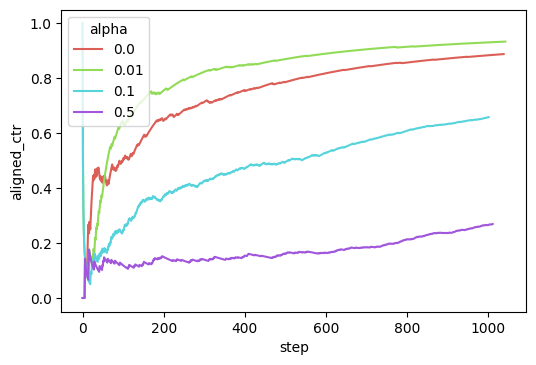

In [30]:
plot(logs, x_key='step', y_key='aligned_ctr', legend_key='alpha', estimator='mean', ci=None)

**Question [5pts]**: What does $\alpha$ affect in LinUCB?

**Answer**: $\alpha$ is a hyperparameter which controls the exploration-exploitation tradeoff. The higher $\alpha$ is, the more inclined the algorithm is to explore rather than exploit.

**Question [5pts]**: Do the reward curves change with $\alpha$? If yes, why? If not, why not?

**Answer**: Yes, the reward curves change with $\alpha$ because the agent places different a emphasis on exploration. When $\alpha = 0.01$ the agent explores more which is beneficial, but we see that for values of $\alpha$ higher than 0.01 performance decreases because the agent does not exploit enough.

In [31]:
#### TODO: modify the UCB agent in the multi-armed bandits, and compare the
#### aligned_ctr curves between bandit, and contextual bandit with alpha as 0, 0.01, 0.5  [10pts] ####
alphas = [0, 0.01, 0.5]
logs_ucb = ctxbandit_sweep([0], data, n_runs=1,context=False)
logs_ucb['alpha'] = 'N/A (context-free UCB)'
logs_lin_ucb = ctxbandit_sweep(alphas, data, n_runs=n_runs)
logs_all = pd.concat((logs_ucb,logs_lin_ucb),axis=0,ignore_index=True)

  0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1 [00:00<?, ?it/s]

Time:   0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Runs:   0%|          | 0/1 [00:00<?, ?it/s]

Time:   0%|          | 0/10000 [00:00<?, ?it/s]

Runs:   0%|          | 0/1 [00:00<?, ?it/s]

Time:   0%|          | 0/10000 [00:00<?, ?it/s]

Runs:   0%|          | 0/1 [00:00<?, ?it/s]

Time:   0%|          | 0/10000 [00:00<?, ?it/s]

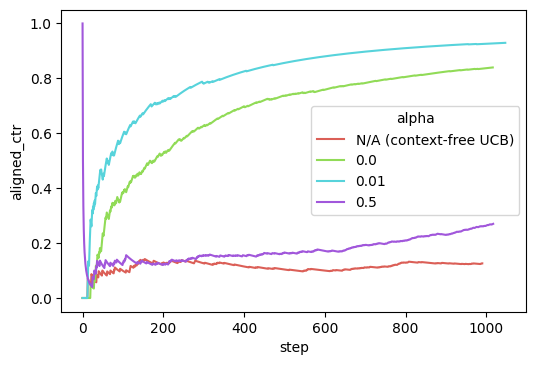

In [32]:
plot(logs_all, x_key='step', y_key='aligned_ctr', legend_key='alpha', estimator='mean', ci=None)

**Question [20pts]**: Does LinUCB outperform UCB? If yes, explain why. If not, explain why not. 

**Answer**: LinUCB outperforms UCB because it leverages feature information when predicting the reward of an action. Intuitively, this should lead to better performance because we know that e.g. a young teenager is going to be interested in a very different set of products than a middle-aged woman. An algorithm that can effectively use feature information to tailor its actions to the user is therefore highly desirable.